<a href="https://colab.research.google.com/github/ma850419/Various_scripts/blob/main/archeology_25june2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='velvety-ring-328419')

In [ ]:
# Based on similar location - modified one to include weights collecting different geographic layers
# to provide to the deep learning model for training
import geemap

# Define region (Brazil, Southeastern Amazon). You can also expand it to other countries
mask = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na', 'Brazil'))
brazil_geometry = mask.geometry()
southeast_brazil = brazil_geometry.intersection(ee.Geometry.Rectangle([-55, -25, -40, -35]))
weights = {
    "B12": 0.10,
    "B11": 0.10,
    "B8": 0.10,
    "VV": 0.10,
    "NDVI": 0.15,
    "Elevation": 0.15,
    "SoilMoisture": 0.10,
    "Thermal": 0.1,
    "Evapotranspiration": 0.1
}
def normalize_band(image, band):
    band_min = image.select(band).reduceRegion(
        reducer=ee.Reducer.min(), geometry=image.geometry(), scale=30, bestEffort=True
    ).get(band)

    band_max = image.select(band).reduceRegion(
        reducer=ee.Reducer.max(), geometry=image.geometry(), scale=30, bestEffort=True
    ).get(band)

    normalized_band = image.select(band).subtract(ee.Number(band_min)).divide(ee.Number(band_max).subtract(ee.Number(band_min)))
    return normalized_band.rename(band + "_norm")
# Load archaeological points
archaeology_points = ee.FeatureCollection("users/mohamadawadlebanon/Archeologicalsites")

# Define date range
start_date = "2024-05-01"
end_date = "2024-05-31"
def apply_scale_and_offset(image):
    return image.select("ST_B10").multiply(0.00341802).add(149.0)
### **Step 1: Elevation Data (ASTER GDEM)**
elevation = ee.Image("projects/sat-io/open-datasets/ASTER/GDEM").clip(southeast_brazil)
#elevation = elevation.rename("Elevation")
elevation = elevation.rename("elevation")
### **Step 2: Sentinel-2 EVI**
sentinel2_ndvi = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .select(["B8", "B4"]) \
    .map(lambda img: img.expression(
        "(B8 - B4) / (B8 + B4)",  # EVI formula
        {"B8": img.select("B8"), "B4": img.select("B4")}
    )).median().clip(southeast_brazil)
sentinel2_ndvi = sentinel2_ndvi.rename("NDVI")

### **Step 3: Sentinel-1 Radar**
sentinel1_images = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV")) \
    .filter(ee.Filter.eq("instrumentMode", "IW")) \
    .select("VV")

mosaiced_sentinel1 = sentinel1_images.median().clip(southeast_brazil)

### **Step 4: Sentinel-2 Optical Mosaic**
sentinel2_images = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .select(["B8", "B11", "B12"])

mosaiced_sentinel2 = sentinel2_images.median().clip(southeast_brazil)

### **Step 5: MODIS Evapotranspiration (ET)**
modis_et = ee.ImageCollection("MODIS/061/MOD16A2") \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .select("ET") \
    .median().clip(southeast_brazil)

### **Step 6: Soil Moisture (NASA SMAP)**
soil_moisture = ee.ImageCollection('NASA/SMAP/SPL4SMGP/007') \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .select('sm_surface') \
    .median().clip(southeast_brazil)

### **Step 7: Thermal Infrared (Landsat 8-9)**
thermal = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(southeast_brazil) \
    .filterDate(start_date, end_date) \
    .map(apply_scale_and_offset) \
    .median().clip(southeast_brazil)


#*** step 8 Normalize all bands

normalized_sentinel1 = normalize_band(mosaiced_sentinel1, "VV")
normalized_ndvi = normalize_band(sentinel2_ndvi, "NDVI")
normalized_elevation = normalize_band(elevation, "elevation")
normalized_soil_moisture = normalize_band(soil_moisture, "sm_surface")
normalized_thermal = normalize_band(thermal, "ST_B10")
normalized_et = normalize_band(modis_et, "ET")

### merge all bands and layers
combined = mosaiced_sentinel2.select("B12").multiply(weights["B12"]) \
.addBands(mosaiced_sentinel2.select("B11").multiply(weights["B11"])) \
.addBands(mosaiced_sentinel2.select("B8").multiply(weights["B8"])) \
.addBands(mosaiced_sentinel1.multiply(weights["VV"])) \
.addBands(sentinel2_ndvi.multiply(weights["NDVI"])) \
.addBands(elevation.multiply(weights["Elevation"])) \
.addBands(soil_moisture.multiply(weights["SoilMoisture"])) \
.addBands(thermal.multiply(weights["Thermal"])) \
.addBands(modis_et.multiply(weights["Evapotranspiration"]))


# Sample feature values at archaeology site locations
sampled_values = combined.sampleRegions(**{
    "collection": archaeology_points,
    "scale": 10,  # Adjust scale depending on resolution needs
    "tileScale": 2
})
# Convert sampled values to FeatureCollection table
def safe_set_coordinates(feature):
    return feature.set({
        "Longitude": feature.get("lon"),
        "Latitude": feature.get("lat")
    })

#table = sampled_values.map(safe_set_coordinates)

task = ee.batch.Export.table.toDrive(
    collection=sampled_values, #table,
    description="Archaeological_Site_Features",
    fileFormat="CSV"
)
task.start()  # Start export task

### **Step 10: Apply K-Means Clustering**
num_classes = 10
training_points = combined.sample(
    region=southeast_brazil,
    # Default (False) is no geometries in the output.
    # When set to True, each feature has a Point geometry at the center of the
    # image pixel.
    geometries=True,
    numPixels = 500,
    # The scale is not specified, so the resolution of the image will be used,
    # and there is a feature for every pixel. If we give a scale parameter, the
    # image will be resampled and there will be more or fewer features.
    #
    scale= 10,
)
# Extract longitude and latitude from geometry

#training_points = training_points.filter(ee.Filter.notNull(['geometry']))
print(training_points.first().getInfo())
task1 = ee.batch.Export.table.toDrive(
    collection=training_points,
    description="Samples_random_collection",
    fileFormat="CSV"
)
task1.start()
clusterer = ee.Clusterer.wekaKMeans(num_classes).train(training_points)
classified = combined.cluster(clusterer)

### **Step 11: Validate Using Archaeological Sites**
validation = classified.sampleRegions(**{
    "collection": archaeology_points,
    "scale": 10,
    "properties": ["class"],
    "tileScale": 2
})

### **Step 12: Visualization Parameters**
vis_params_elevation = {"bands": ["elevation"], "min": 0, "max": 3000, "palette": ["black", "white"]}
vis_params_ndvi = {"bands": ["NDVI"],"min": -0.6, "max": 0.6, "palette": ["brown", "green"]}
vis_params_s1 = {"bands": ["VV"], "min": -20, "max": 0, "gamma": 1.4}
vis_params_s2 = {"bands": ["B12", "B11", "B8"], "min": 0, "max": 3000, "gamma": 1.4}
vis_params_modis_et = {"bands": ["ET"], "min": 0, "max": 300, "palette": ["yellow", "green", "blue"]}
#vis_params_pml_et = {"min": 0, "max": 5, "palette": ["orange", "red", "purple"]}
vis_params_soil = {"bands": ["sm_surface"], "min": 0, "max": 0.9, "palette": ["red", "orange", "yellow", "green"]}
vis_params_thermal = {"bands": ["ST_B10"], "min": 270, "max": 320, "palette": ["blue", "yellow", "red"]}
vis_params_classified = {
    "min": 0,
    "max": num_classes - 1,
    "palette": ["blue", "green", "yellow", "red", "purple", "orange", "brown", "cyan", "pink", "gray"]
}
archaeology_vis = {"color": "blue", "pointRadius": 5}
sample_vis = {"color": "black", "pointRadius": 4}
### **Step 13: Create & Display Map**
m = geemap.Map(center=[-3, -60], zoom=6)

m.addLayer(elevation, vis_params_elevation, "ASTER GDEM v3 Elevation")
m.addLayer(sentinel2_ndvi, vis_params_ndvi, "High-Resolution NDVI (Sentinel-2)")
m.addLayer(mosaiced_sentinel1, vis_params_s1, "Sentinel-1 Mosaic (Radar)")
m.addLayer(mosaiced_sentinel2, vis_params_s2, "Sentinel-2 Mosaic (Optical)")
m.addLayer(modis_et, vis_params_modis_et, "MODIS Evapotranspiration")
#m.addLayer(pml_et, vis_params_pml_et, "PML Evapotranspiration")
m.addLayer(soil_moisture, vis_params_soil, "Soil Moisture (SMAP)")
m.addLayer(thermal, vis_params_thermal, "Thermal Infrared (Landsat)")
m.addLayer(classified, vis_params_classified, "Classified Image (K-Means)")
m.addLayer(archaeology_points, archaeology_vis, "Archaeology Points")
m.addLayer(training_points,sample_vis, "sample Points")

# Display the map
m


In [6]:
# read known archeological sites
import csv
import numpy as np
with open("/content/Archaeological_Site_Features_2.csv") as infile:
    reader = csv.reader(infile, delimiter=",")
    next(reader, None)
    data3 =np.array(list(reader))

In [7]:
# Define the type of read parameters for the training of the model
dtype1 = np.dtype([('B12', np.float32),('B11', np.float32),('B8', np.float32),('VV', np.float32),('NDVI', np.float32), ('Elevation', np.float32), ('SM', np.float32), ('ST', np.float32),('ET', np.float32),('Latitude', np.float32),('Longitude', np.float32) , ('Name', np.str_),('Class', np.int32)])
arr2 = np.zeros((len(data3),)).astype(dtype1)

In [8]:
# assign read data to another array of predefined type dtype1
arr2['B11'] = data3[:, 0]
arr2['B12'] = data3[:, 1]
arr2['B8'] = data3[:, 2]
arr2['ET'] = data3[:, 6]
arr2['NDVI'] = data3[:, 5].astype(np.float32)
arr2['ST'] = data3[:, 8].astype(np.float32)
arr2['VV'] = data3[:, 3].astype(np.float32)
arr2['Elevation'] = data3[:, 4]
arr2['SM'] = data3[:, 7]
arr2['Latitude'] = data3[:, 9]
arr2['Longitude'] = data3[:, 10]
arr2['Name'] = data3[:, 11]
arr2['Class'] = data3[:, 12]

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Input,Reshape
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
# Define custom loss function (MSE + small L1 penalty)
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true)) + 0.01 * tf.reduce_sum(tf.abs(y_pred))
def r2_score(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (SS_res / (SS_tot + tf.keras.backend.epsilon()))
# Define feature columns (exclude Name, Latitude, Longitude)
feature_columns = ['B12', 'B11', 'B8', 'VV',  'NDVI', 'Elevation', 'SM', 'ST', 'ET']

X_structured = arr2[feature_columns]  # Extract features
# Extract latitude & longitude properly from the structured array
# Convert latitude & longitude to arcseconds (precision boost)
arr2['Latitude'] = arr2['Latitude'] #* 3600
arr2['Longitude'] = arr2['Longitude']# * 3600
y = np.stack([arr2['Latitude'], arr2['Longitude']], axis=1).astype(np.float32)
X = np.stack([X_structured[col] for col in feature_columns], axis=1).astype(np.float32)
X_lstm1 = X.reshape((X.shape[0], 1, X.shape[1]))
# Normalize features using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)  # Scale features

scaler_y = MinMaxScaler()#feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)

# Reshape X to fit LSTM input format (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 timestep

# Build LSTM model for predicting Latitude & Longitude of possible archeological sites

input_layer = Input(shape=(1, len(feature_columns)))
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.1)))(input_layer)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.1))(x)
x = Dropout(0.3)(x)

x = LSTM(64, kernel_regularizer=l2(0.1))(x)
x = Dropout(0.2)(x)

x = Reshape((1, 64))(x)  # Ensure 3D shape
x = LSTM(32, kernel_regularizer=l2(0.1), return_sequences=False)(x)
x = Dropout(0.2)(x)

# Dense layers
x = Dense(16, activation='relu', kernel_regularizer=l2(0.1))(x)
output_layer = Dense(2)(x)  # Predicts Latitude & Longitude
# Build model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model with MSE loss (regression task)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss=custom_loss, metrics= ['mse'])#['mse'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.Huber(delta=0.01),  # More robust loss function
              metrics=['mse'])

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.Huber(delta=1.0),metrics= ['mse'])#, metrics=['r2_score'])
# Summary of the model
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 512)         │       544,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 937,394 (3.58 MB)

 Trainable params: 936,370 (3.57 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - loss: 78.1959 - mse: 1522.0446 - val_loss: 65.1178 - val_mse: 1496.5117
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 61.5324 - mse: 1519.2723 - val_loss: 50.8218 - val_mse: 1493.7474
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 47.9359 - mse: 1517.4506 - val_loss: 39.3749 - val_mse: 1490.8711
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 37.1007 - mse: 1514.4354 - val_loss: 30.3916 - val_mse: 1487.9703
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 28.6296 - mse: 1511.0233 - val_loss: 23.4522 - val_mse: 1484.9376
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.1045 - mse: 1507.6044 - val_loss: 18.1544 - val_mse: 1481.8207
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 17.1330 - mse: 1505.6851 - val_loss: 14.1415 - val_mse: 1478.5970
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 13.3714 - mse: 1501.5963 - val_loss: 11.1147 - val_mse: 1475.2380
Epoch 9/30
7/7

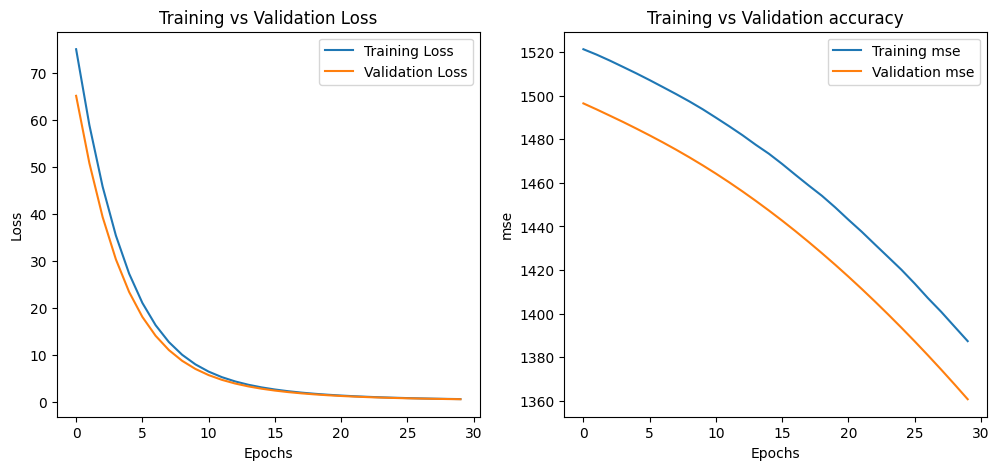

In [10]:
# Extract numeric values from the structured array
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_lstm1, y, epochs=30, batch_size=16, validation_split=0.2, callbacks=[early_stopping])
# Predict longitude & latitude for new site features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot accuracy using MSE (lower is better)
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training mse')
#lt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_mse'], label='Validation mse')
#plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
#plt.ylabel('Mean Squared Error')
plt.ylabel('mse')
plt.title('Training vs Validation accuracy')
plt.legend()

plt.show()


In [11]:
import csv
import numpy as np
with open("/content/Samples_random_collection_2.csv") as infile:
    reader = csv.reader(infile, delimiter=",")
    next(reader, None)
    data4 =np.array(list(reader))

In [12]:
dtype3 = np.dtype([('B11', np.float32),('B12', np.float32),('B8', np.float32), ('ET', np.float32),('NDVI', np.float32), ('ST', np.float32),('VV', np.float32),('Elevation', np.float32),('SM', np.float32) ])
arr4 = np.zeros((len(data4),)).astype(dtype3)

In [13]:
arr4['B11'] = data4[:, 0]
arr4['B12'] = data4[:, 1]
arr4['B8'] = data4[:, 2]
arr4['ET'] = data4[:, 3]
arr4['NDVI'] = data4[:, 4].astype(np.float32)
arr4['ST'] = data4[:, 5].astype(np.float32)
arr4['VV'] = data4[:, 6].astype(np.float32)
arr4['Elevation'] = data4[:, 7]
arr4['SM'] = data4[:, 8]

In [ ]:
import pandas as pd
import numpy as np

# Define feature columns
feature_columns = ['B11', 'B12', 'B8','ET',  'NDVI',  'ST','VV', 'Elevation', 'SM']

# Prepare input data
new_data_for_scaling = np.stack([arr4[col] for col in feature_columns], axis=1).astype(np.float32)

# Normalize the new data
#new_scaled = scaler.transform(new_data_for_scaling)

# Reshape for LSTM input format
#new_lstm_ready = new_scaled.reshape((new_scaled.shape[0], 1, new_scaled.shape[1]))
new_lstm_ready = new_data_for_scaling.reshape((new_data_for_scaling.shape[0], 1, new_data_for_scaling.shape[1]))
# Make predictions (now expecting longitude & latitude)
predicted_coords_scaled = model.predict(new_lstm_ready)
#predicted_coords = scaler_y.inverse_transform(predicted_coords_scaled)
# Convert predictions to a DataFrame
results_df = pd.DataFrame(new_data_for_scaling, columns=feature_columns)  # Original input features

# Add predicted longitude & latitude columns
results_df['Predicted_Longitude'] = predicted_coords_scaled[:, 1]  # First column = longitude
results_df['Predicted_Latitude'] = predicted_coords_scaled[:, 0]  # Second column = latitude

# Save results to a CSV file
results_df.to_csv('predicted_coordinates.csv', index=False)

print("Predicted latitude and longitude saved to predicted_coordinates.csv")


In [ ]:
print(results_df)

In [ ]:
import numpy as np

# True vs predicted coordinates
true_lat = arr2["Latitude"]
true_lon = arr2["Longitude"]
pred_lat = results_df['Predicted_Latitude']#predicted_coords[:, 0]  # Latitude
pred_lon =results_df['Predicted_Longitude']# predicted_coords[:, 1]  # Longitude
print('true latitude',true_lat)
print('true longitude',true_lon)
print('predi latitude',pred_lat)
print('predited longitude',pred_lon)
# Calculate absolute errors for each point
lat_errors = np.abs(true_lat - pred_lat)
lon_errors = np.abs(true_lon- pred_lon)

# Compute mean errors
mean_lat_error = np.mean(lat_errors)
mean_lon_error = np.mean(lon_errors)

print("Individual Latitude Errors:", lat_errors)
print("Mean Latitude Error:", mean_lat_error)
print("Individual Longitude Errors:", lon_errors)
print("Mean Longitude Error:", mean_lon_error)



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot true locations
plt.scatter(arr2["Longitude"], arr2["Latitude"], color='green', label='True Locations', marker='o')

# Plot predicted locations
#plt.scatter(pred_lon[:, 1], pred_lat[:, 0], color='red', label='Predicted Locations', marker='x')
# Plot predicted locations
plt.scatter(pred_lon.values, pred_lat.values, color='red', label='Predicted Locations', marker='x')
# Connect true and predicted points to show displacement
#for i in range(len(true_coords)):
#    plt.plot([true_coords[i, 0], pred_coords[i, 0]], [true_coords[i, 1], pred_coords[i, 1]], color="gray", linestyle="dashed", alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("True vs. Predicted Locations of Archaeological Sites")
plt.legend()
plt.grid()
plt.show()



In [ ]:
dtype2 = np.dtype([('B11', np.float32),('B12', np.float32),('B8', np.float32), ('ET', np.float32),('NDVI', np.float32), ('ST', np.float32),('VV', np.float32),('Elevation', np.float32),('SM', np.float32),('Longitude', np.float32),('Latitude', np.float32) ])
arr3 = np.zeros((len(data4),)).astype(dtype2)

In [ ]:
arr3['B11'] = data4[:, 0]
arr3['B12'] = data4[:, 1]
arr3['B8'] = data4[:, 2]
arr3['ET'] = data4[:, 3]
arr3['NDVI'] = data4[:, 4].astype(np.float32)
arr3['ST'] = data4[:, 5].astype(np.float32)
arr3['VV'] = data4[:, 6].astype(np.float32)
arr3['Elevation'] = data4[:, 7]
arr3['SM'] = data4[:, 8]
arr3['Longitude'] = data4[:, 9]
arr3['Latitude'] = data4[:, 10]

In [ ]:
# prediction module
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
feature_columns = ['B11', 'B12', 'B8','VV', 'Elevation','NDVI','ET', 'SM', 'ST']
# Prepare input data
new_data_for_scaling = np.stack([arr3[col] for col in feature_columns], axis=1).astype(np.float32)

# Normalize the new data
new_scaled = scaler.transform(new_data_for_scaling)

# Reshape for LSTM input format
new_lstm_ready = new_scaled.reshape((new_scaled.shape[0], 1, new_scaled.shape[1]))

# Make predictions
predicted_classes = model.predict(new_lstm_ready)

# Convert predictions to a DataFrame
results_df = pd.DataFrame(new_data_for_scaling, columns=feature_columns)  # Original input features
results_df['Predicted_Class'] = predicted_classes.flatten()  # Add predictions
results_df['Longitude'] = arr3['Longitude']
results_df['Latitude'] = arr3['Latitude']
# Save results to a CSV file
results_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")

In [ ]:
# This is based on the class
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
# Define feature columns (exclude Name, Latitude, Longitude)
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true)) + 0.01 * tf.reduce_sum(tf.abs(y_pred))
feature_columns = ['B11', 'B12', 'B8','VV', 'Elevation','NDVI','ET', 'SM', 'ST']
X_structured = arr2[feature_columns]  # Extract features
y = arr2[['Class']]  # Binary target (1 for archaeology, 0 for non-archaeology)
X = np.stack([X_structured[col] for col in feature_columns], axis=1).astype(np.float32)
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape to fit LSTM input format: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 timestep

# Build LSTM model for binary classification
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, len(feature_columns))),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output: Binary classification (archaeological site or not)
])

model.compile(optimizer=Adam(learning_rate=0.0001),loss=custom_loss,metrics=['mse'])# loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


In [ ]:
y = np.stack([arr2['Class']], axis=1).astype(np.float32)
model.fit(X_lstm, y, epochs=30, batch_size=32, validation_split=0.2)